<a href="https://colab.research.google.com/github/cosez/CheckSignin/blob/main/Treinamento_para_projeto_IBTU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# univariate multi-step cnn for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[:-12], data[-12:]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/4))
    test = array(split(test, len(test)/12))
    return train, test

In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    matrix = np.corrcoef(actual, predicted)
    print('Matriz: ', matrix[0,1])
    plt.scatter(actual, predicted)
    plt.xlabel('Actual')
    plt.ylabel('Predictions')
    plt.title('Actual vs. Predictions')
    plt.show()
    return score, scores

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))


In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=12):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [ ]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Conv1D(16, 3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [ ]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], 1))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    print('Input SHAPE: ',input_x.shape)
    print('Input para predição: ',input_x)
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    print('YHAT SHAPE',yhat.shape)
    print('YHAT[0]: ',yhat[0])
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [ ]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    print('Predictions: ', predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores


Input SHAPE:  (1, 4, 1)
Input para predição:  [[[76.34403671]
  [53.65738591]
  [51.78999157]
  [54.06294643]]]
YHAT SHAPE (1, 12)
YHAT[0]:  [48.728294   41.991      42.356133   34.788628   59.41739    38.04472
 41.65429    35.404324    1.529218   -0.08804902 45.652603   55.80986   ]
Predictions:  [[48.728294   41.991      42.356133   34.788628   59.41739    38.04472
  41.65429    35.404324    1.529218   -0.08804902 45.652603   55.80986   ]]
Matriz:  0.1323301591566368


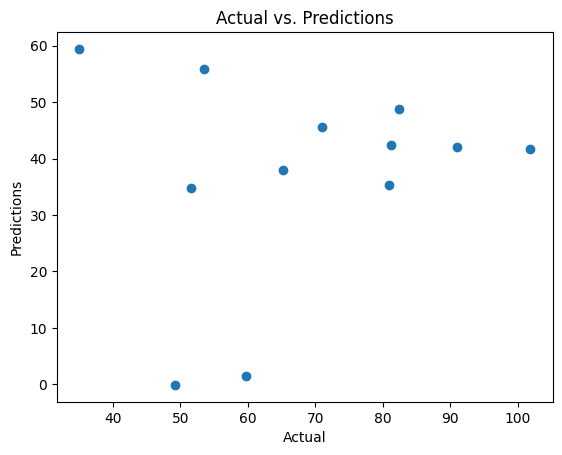

cnn: [39.605] 33.7, 49.1, 38.8, 16.8, 24.4, 27.1, 60.2, 45.5, 58.2, 49.3, 25.4, 2.3


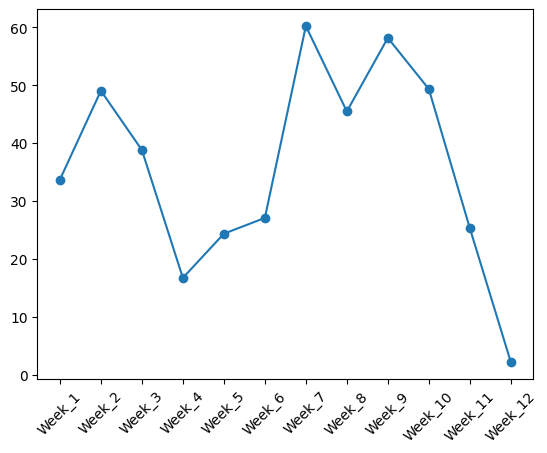

In [ ]:
# load the new file
dataset = read_csv('//Austrália/Potência_Diaria_ARWF1.csv', index_col=0, parse_dates=True)
#adjusting from daily to weekly using the mean
resample_weekly_DF = dataset.resample('W')
weekly_sum_power_DF = resample_weekly_DF.mean()
weekly_sum_power_DF = weekly_sum_power_DF.iloc[:-1]
dataset = weekly_sum_power_DF['ARWF1']
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 4
score, scores = evaluate_model(train.reshape(train.shape[0], train.shape[1], 1), test.reshape(test.shape[0], test.shape[1], 1), n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
weeks = ['Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6', 'Week_7', 'Week_8', 'Week_9', 'Week_10', 'Week_11', 'Week_12']
pyplot.plot(weeks, scores, marker='o', label='cnn')
plt.xticks(rotation=45)
pyplot.show()

In [ ]:
train.shape

(10, 4)

In [ ]:
dataset.tail(12)

2018-10-14     82.442510
2018-10-21     91.044891
2018-10-28     81.184075
2018-11-04     51.562698
2018-11-11     35.025198
2018-11-18     65.160696
2018-11-25    101.867063
2018-12-02     80.886260
2018-12-09     59.692418
2018-12-16     49.261508
2018-12-23     71.010677
2018-12-30     53.545585
Freq: W-SUN, Name: ARWF1, dtype: float64

In [ ]:
dataset.describe()

count     52.000000
mean      67.668068
std       25.681109
min       23.689881
25%       51.714484
50%       61.568208
75%       83.878819
max      145.072917
Name: ARWF1, dtype: float64